In [5]:
import gymnasium as gym
import seaborn as sns
import os
from collections import deque, Counter, namedtuple, defaultdict
import random
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import torch
from torch import nn
import torch.nn.functional as F
import math
from itertools import count
from tqdm import tqdm
import numpy as np
import time
import cv2

#Setting up matplotlib for live update the traiing progress
import matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


# Car Racing Env

https://hiddenbeginner.github.io/study-notes/contents/tutorials/2023-04-20_CartRacing-v2_DQN.html

Actions: space of 3 if float type
- (-1: full left ---> +1: full right): float or discrete
- gas: float or discrete
- brake: float or discrete

Actions: space of 5 if int type 
- (do nothing, left, right, gas, brake)

Observation:
- 96x96x3 color image

Rewards:
- The reward is -0.1 every frame and +1000/N for every track tile visited, where N is the total number of tiles visited in the track. For example, if you have finished in 732 frames, your reward is 1000 - 0.1*732 = 926.8 points.

Termination
- if car goes of out of track, -100 reward
- when all tiles are visited

NOTES:
the first 50 frames is zooming in so we'll not use them 


obs shape =  (96, 96, 3)


100%|██████████| 1/1 [00:21<00:00, 21.24s/it]


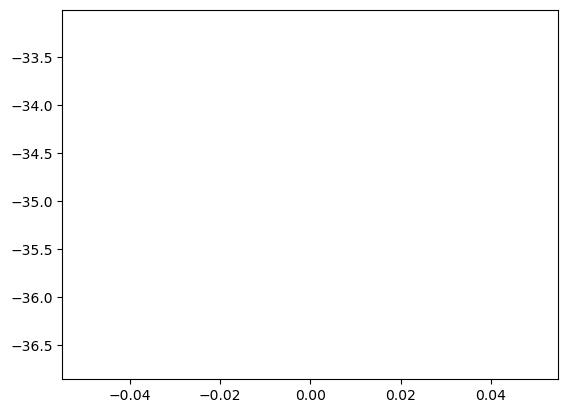

In [6]:
env = gym.make('CarRacing-v2', render_mode = 'human')
obs, info = env.reset()
print('obs shape = ', obs.shape)

rewards = []
for ep in tqdm(range(1)):
    obs, info = env.reset()
    total_reward = 0

    for t in count():
        action = env.action_space.sample()
        state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        if terminated or truncated: 
            break
    
    rewards.append(total_reward)

sns.lineplot(y = rewards, x = list(range(len(rewards))))
plt.show()
env.close()

# Env Wrapper

TODO:
- stack 4 frames 
- convert color image to gray scale. The final input shape is (4x96x96) 
- scale the image if needed

In [7]:
# a = np.random.rand(4,84,84)
# print(a.shape)
# print(a[:,:,np.newaxis].shape)

In [8]:
def _default_process_fn(img):
    #84x84 because we're following the DQN paper
    img = cv2.resize(img, dsize=(84,84))
    #convert and scale to 0.0 --> 1.0
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) / 255.0
    return img

env = gym.make('CarRacing-v2', render_mode = 'human')
obs, info = env.reset()
state, info = env.reset()

state = _default_process_fn(state)
print(state.shape)
print(state)
env.close()

(84, 84)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [9]:
class RacingCarEnvWrapper(gym.Wrapper):

    def __init__(self, env ,start_frame = 50, stack_frames = 4, skip_frames = 4, process_fn = None):
        super().__init__(env)
        self.start_frame = start_frame
        self.stack_frames = stack_frames
        self.skip_frames = skip_frames
        self.process_fn = self._default_process_fn if process_fn == None else process_fn
    
    def _default_process_fn(self, img):
        #84x84 because we're following the DQN paper
        img = cv2.resize(img, dsize=(84,84))
        #convert and scale to 0.0 --> 1.0
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) / 255.0
        return img
    
    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        for _ in range(self.start_frame):
            state, reward, terminated, truncated, info = self.env.step(self.env.action_space.sample())

        #preprocess the image to gray scale and resize to (84x84)
        state = self.process_fn(state)
        # since we only have 1 state initally, we'll repeat that state stack_frames times
        # so (84x84) to 484x84
        self.stacked_state = np.tile(state, (self.stack_frames, 1,1))
        return self.stacked_state, info

    def step(self, action, **kwargs):
        total_reward = 0
        #skip N frames
        for _ in range(self.skip_frames):
            state, reward, terminated, truncated, info = self.env.step(action)
            total_reward += reward
            if terminated or truncated: break
        
        state = self.process_fn(state)

        #we ignore the 0th in stacked state, ==> stack [1:N] and concat with new state
        #state[np.newaxis] is like torch.unsqueeze(0), add new dim 
        # so state = (84x84) becomes 1 x 84 x 84
        self.stacked_state = np.concatenate((self.stacked_state[1:], state[np.newaxis]), axis = 0)
        # stacked state is 4x84x84
        return self.stacked_state, reward, terminated, truncated, info
    
    def action_sample(self):
        return self.env.action_space.sample()
    
    def close(self):
        self.env.close()


# Greedy Epsilon

In [10]:
def get_action(state, policy_net, eps, env: RacingCarEnvWrapper):
    p = random.random()
    #exploit
    if p > eps:
        policy_net.eval()
        state = torch.tensor(state).float().unsqueeze(0).to(policy_net.device)
        with torch.no_grad():
            action = np.argmax(policy_net(state).cpu().numpy())
        policy_net.train()
        return action
    else:
        return env.action_sample()


# Epsilon Functions

In [11]:
def epsilon_linear_decay(min_ep, max_ep, decay_ep, epoch, training_epochs):
    return max(min_ep, max_ep * (decay_ep ** epoch))

def plot_epsilon_decay(min_ep, max_ep, decay_ep, training_epochs, epsilon_function):
    eps = []
    for e in range(training_epochs):
        eps.append(epsilon_function(min_ep, max_ep, decay_ep, e, training_epochs))
    sns.lineplot(y = eps, x = list(range(len(eps))))
    plt.show()

# DQN architecture

Reference: 

https://github.com/vwxyzjn/cleanrl/blob/master/cleanrl/dqn_atari.py

https://hiddenbeginner.github.io/study-notes/contents/tutorials/2023-04-20_CartRacing-v2_DQN.html

input image must be converted to graysale and stack 4 frames 
- Conv(input = 4 (stack 4 frames technique), output = 32, kernel_size = 8, stride = 4)
- ReLU()
- Conv(input = 32, output = 64, kernel_size = 4, stride = 2)
- ReLU()
- Conv(input = 64, output = 64, kernel_size = 3, stride = 1)
- ReLU()
- Flatten()
- LazyLinear(512)
- ReLU()
- LazyLinear(512, action_space)




In [12]:
class QNet(nn.Module):
    def __init__(self, input_channels, output_size, device, activation = F.relu, lr = 1e-4) -> None:

        super().__init__()

        #Archicture follows DQN paper
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=8, stride = 4)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride = 2)
        self.fc1 = nn.LazyLinear(256)
        self.fc2 = nn.Linear(256, output_size)
        self.activation = activation

        # self.tau = tau
        self.optimizer = torch.optim.Adam(self.parameters(), lr = lr)
        self.criterion = nn.MSELoss()
        
        self.device = device

        self.to(device)
    
    def forward(self, X):
        X = self.activation(self.conv1(X))
        X = self.activation(self.conv2(X))
        X = torch.flatten(X,1)
        X = self.fc1(X)
        X = self.fc2(X)
        return X

    def optimize(self, input, target):
        loss = self.criterion(input, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
    def sync(self, other_net:nn.Module):
        self.load_state_dict(other_net.state_dict())
        #  for param, other_param in zip(self.parameters(), other_net.parameters()):
        #     param.data.copy_(self.tau*other_param.data + (1.0-self.tau)*param.data)

In [13]:

x = torch.rand(32,4,84,84).to(DEVICE)
net = QNet(4,5, device = DEVICE)
output = net(x)
print(output.shape)

torch.Size([32, 5])


reset state =  (4, 84, 84)


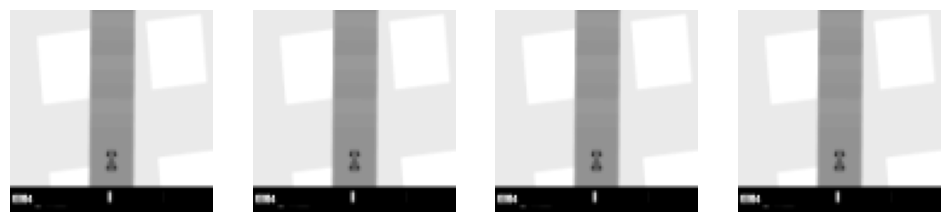

reset state shape =  torch.Size([1, 4, 84, 84])
init output shape =  torch.Size([1, 5])
state after action =  (4, 84, 84)


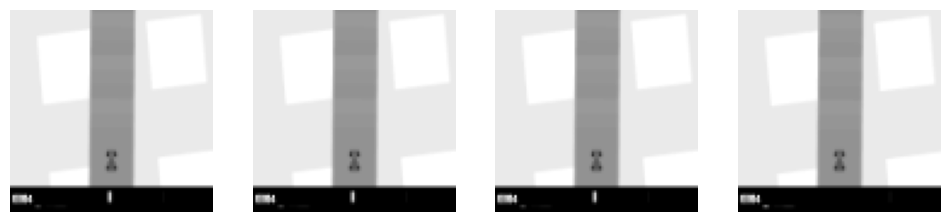

explore =  4
exploit =  1


In [14]:
#  Put them all together

base_env = gym.make('CarRacing-v2', render_mode = 'human', continuous=False)
env = RacingCarEnvWrapper(base_env)

state, info = env.reset()
print('reset state = ', state.shape)

#Visualize what the input image looks like

fig, axes = plt.subplots(1,4,figsize=(12,3))
for i in range(4):
    axes[i].imshow(state[i], cmap='gray')
    axes[i].axis('off')

plt.show()

# Init DQN

net = QNet(input_channels=4, output_size = base_env.action_space.n, device = DEVICE)
state = torch.tensor(state).float().unsqueeze(0).to(DEVICE)
print('reset state shape = ', state.shape)

output = net(state)
print('init output shape = ', output.shape)

state, reward, terminated, truncated, info = env.step(3)
print('state after action = ', state.shape)

fig, axes = plt.subplots(1,4,figsize=(12,3))
for i in range(4):
    axes[i].imshow(state[i], cmap='gray')
    axes[i].axis('off')

plt.show()


#test greedy policy
state, info = env.reset()

explore = get_action(state, net, 1.0, env)
print('explore = ' , explore)
exploit = get_action(state, net, 1.0, env)
print('exploit = ' , exploit)

env.close()

# Replay Memory

In [15]:
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayMemory():
    def __init__(self, capacity, device) -> None:
        self.capacity = capacity
        self.memory = deque(maxlen = capacity)
        self.device = device
    
    def push(self, state, action, reward, next_state, done):
        self.memory.append(Transition(state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        '''
        @params: 
            batch_size: int
        @return:
            states: torch.tensor
            actions: torch.tensor
            rewards: torch.tensor
            next_states: torch.tensor
            done: torch.tensor
        '''
        if batch_size > len(self.memory): return None
        transitions = random.sample(self.memory, batch_size)
        batch = Transition(*zip(*transitions))

        state_batch = torch.tensor(batch.state).float().to(self.device)
        action_batch = torch.tensor(np.vstack(batch.action)).long().to(self.device)
        reward_batch = torch.tensor(np.vstack(batch.reward)).float().to(self.device)
        next_state_batch = torch.tensor(batch.next_state).float().to(self.device)
        done_batch = torch.tensor(np.vstack(batch.done)).float().to(self.device)

        return (state_batch, action_batch, reward_batch, next_state_batch, done_batch)
    
    def __len__(self):
        return len(self.memory)
    
    def clear(self):
        self.memory.clear()

# Training Loop

In [16]:
ROOT = os.getcwd()
OUTPUT = os.path.join(ROOT, 'output','car_racing')

if os.path.exists(OUTPUT) == False:
    os.makedirs(OUTPUT)

In [17]:
def tune(
    lr = 0.00025,
    min_ep = 0.1,
    max_ep = 1.0,
    decay_ep = 0.999,
    training_epochs = 1000,
    gamma = 0.99,
    batch_size = 32,
    warmup_steps = 5000, #TODO: what's this?
    memory_capacity = int(1e5), #TODO: DQM paper uses 1e6
    target_update_interval = 10,
    plot_update_freq = 10,
    label = 'default'
):
    SAVE_PATH = os.path.join(OUTPUT, label)
    fig_save_path = os.path.join(SAVE_PATH, 'plot.png')

    if os.path.exists(SAVE_PATH) == False:
        os.makedirs(SAVE_PATH)

    base_env = gym.make('CarRacing-v2', continuous=False)
    env = RacingCarEnvWrapper(base_env)

    state, info = env.reset()

    state_size = state.shape
    action_size = base_env.action_space.n

    stacked_frames = state_size[0]
    print('state shape = ', state_size)
    print('action size = ', action_size)

    policy_net = QNet(input_channels = stacked_frames, output_size = action_size, device = DEVICE)
    target_net = QNet(input_channels = stacked_frames, output_size = action_size, device = DEVICE)

    memory = ReplayMemory(memory_capacity, device = DEVICE)

    score_window = deque(maxlen=100)

    step_count = 0

    history = defaultdict(list)

    loop = tqdm(range(training_epochs))
    best_avg_reward = 0

    for epoch in loop:
        total_reward = 0
        done = False
        state, info = env.reset()

        epsilon = epsilon_linear_decay(min_ep, max_ep, decay_ep, epoch, training_epochs)

        for t in count():

            step_count += 1

            action = get_action(state, policy_net, epsilon, env)
            next_state, reward, terminated, truncated, info = env.step(action)

            total_reward += reward

            if terminated or truncated: 
                done = True
            
            memory.push(state, action, reward, next_state, done)

            state = next_state

            transitions = memory.sample(batch_size)

            if transitions != None:
                #optimize
                states, actions, rewards, next_states, dones = transitions
                # print('states shape = ', states.shape)
                # print('action shape = ', actions.shape)
                # print('rewards shape = ', rewards.shape)
                # print('next state shape = ', next_states.shape)
                # print('dones shape = ', dones.shape)

                next_state_values = target_net(next_states).detach().max(1)[0].unsqueeze(1)

                next_state_values = reward + gamma * next_state_values * (1 - dones)
                # print('next_state_values after reward + shape = ', next_state_values.shape)

                state_values = policy_net(states).gather(1, actions)
                # print('state_values shape = ', state_values.shape)

                policy_net.optimize(state_values, next_state_values)

                if step_count % target_update_interval:
                    target_net.sync(policy_net)
                

            if done:
                break

        score_window.append(total_reward)
        avg_reward = np.mean(score_window)

        if best_avg_reward <= avg_reward:
            best_avg_reward = avg_reward
            #save best model
            torch.save(policy_net, os.path.join(SAVE_PATH, 'policy_net.checkpoint.torch'))
            torch.save(target_net, os.path.join(SAVE_PATH, 'target_net.checkpoint.torch'))


        loop.set_description(f'epoch = {epoch}, epsilon = {epsilon:.2f}, avg rewards={np.mean(score_window):.2f}, best_avg_reward={best_avg_reward:.2f}')
        history['reward'].append(avg_reward)
        history['epsilon'].append(epsilon)

        if epoch % plot_update_freq == 0:
            plot(history, save_path = fig_save_path)
        
    torch.save(policy_net, os.path.join(SAVE_PATH, 'policy_net.final.torch'))
    torch.save(target_net, os.path.join(SAVE_PATH, 'target_net.final.torch'))

    plot(history, show = True)
    fig_save_path = os.path.join(SAVE_PATH, 'plot.png')

def plot(history, show = False, save_path = None):
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
    sns.lineplot(y = history['reward'], x = list(range(len(history['reward']))), ax = ax1)
    ax1.set_title('100-iteration average reward per epoch')
    sns.lineplot(y = history['epsilon'], x = list(range(len(history['epsilon']))), ax = ax2)
    ax2.set_title(label = 'epsilon decay')

    if save_path != None:
        plt.savefig(save_path)
    if show:
        plt.show()



In [3]:
def tunev2(
    device,
    lr = 0.00025,
    min_ep = 0.1,
    max_ep = 1.0,
    decay_ep = 0.999,
    max_steps = 20000,
    gamma = 0.99,
    batch_size = 32,
    warmup_steps = 5000, #TODO: what's this?
    memory_capacity = int(1e5), #TODO: DQM paper uses 1e6
    target_update_interval = 10,
    plot_update_freq = 50,
    label = 'default'
):
    SAVE_PATH = os.path.join(OUTPUT, label)

    if os.path.exists(SAVE_PATH) == False:
        os.makedirs(SAVE_PATH)

    base_env = gym.make('CarRacing-v2', continuous=False)
    env = RacingCarEnvWrapper(base_env)

    state, info = env.reset()

    state_size = state.shape
    action_size = base_env.action_space.n

    stacked_frames = state_size[0]
    print('state shape = ', state_size)
    print('action size = ', action_size)

    policy_net = QNet(input_channels = stacked_frames, output_size = action_size, device = DEVICE, lr = lr)
    target_net = QNet(input_channels = stacked_frames, output_size = action_size, device = DEVICE, lr = lr)

    memory = ReplayMemory(memory_capacity, device = DEVICE)

    score_window = deque(maxlen=100)

    step_count = 0

    history = defaultdict(list)

    loop = tqdm(range(max_steps))
    best_avg_reward = 0

    total_reward = 0
    done = False
    state, info = env.reset()

    for step in loop:

        epsilon = epsilon_linear_decay(min_ep, max_ep, decay_ep, step, max_steps)

        action = get_action(state, policy_net, epsilon, env)
        next_state, reward, terminated, truncated, info = env.step(action)

        total_reward += reward

        if terminated or truncated: 
            done = True
        
        memory.push(state, action, reward, next_state, done)

        state = next_state

        transitions = memory.sample(batch_size)

        #optimize
        if transitions != None:
            states, actions, rewards, next_states, dones = transitions

            next_state_values = target_net(next_states).detach().max(1)[0].unsqueeze(1)

            next_state_values = reward + gamma * next_state_values * (1 - dones)

            state_values = policy_net(states).gather(1, actions)

            policy_net.optimize(state_values, next_state_values)

            if step_count % target_update_interval:
                target_net.sync(policy_net)
            
        
        if done:
            #reset environment
            state, info = env.reset()


        score_window.append(total_reward)
        avg_reward = np.mean(score_window)
        loop.set_description(f'step = {step}, epsilon = {epsilon:.2f}, avg rewards={avg_reward:.2f}, best_avg_reward={best_avg_reward:.2f}')


    #     history['reward'].append(np.mean(score_window))
    #     history['epsilon'].append(epsilon)
    #     fig_save_path = os.path.join(SAVE_PATH, 'plot.png')

    #     if epoch % plot_update_freq == 0:
    #         plot(history, save_path = fig_save_path)
        
    # torch.save(policy_net, os.path.join(SAVE_PATH, 'policy_net.final.torch'))
    # torch.save(target_net, os.path.join(SAVE_PATH, 'target_net.final.torch'))

    # plot(history, show = True)

def plot(history, show = False, save_path = None):
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
    sns.lineplot(y = history['reward'], x = list(range(len(history['reward']))), ax = ax1)
    ax1.set_title('100-iteration average reward per epoch')
    sns.lineplot(y = history['epsilon'], x = list(range(len(history['epsilon']))), ax = ax2)
    ax2.set_title(label = 'epsilon decay')

    if save_path != None:
        plt.savefig(save_path)
    if show:
        plt.show()

In [ ]:
tunev2(DEVICE)

# NOTES

for images, we need to stack 4 frames (DeepMind method) to make a 4x3x96x96 input shape. This gives the model some information about velocity and direction of stuff